In [1]:
# Instalamos la librería Fiona
!pip install fiona

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 47.6 MB/s eta 0:00:00


In [2]:
# Importamos la función listlayers de Fiona
from  fiona import listlayers

# Definimos el enlace directo al archivo GeoPackage (.gpkg) alojado en GitHub
# Este archivo contiene datos geoespaciales relacionados con el mapa de la India
indiaMapsLink='https://github.com/in-Sinergy/IndiaData/raw/main/newindiaMaps_24378.gpkg'

# Usamos la función listlayers() para listar las capas disponibles en el archivo GeoPackage
listlayers(indiaMapsLink)

['country',
 'cities',
 'rivers',
 'centroid',
 'airports',
 'border',
 'states',
 'municipalities']

In [3]:
# Importamos la librería GeoPandas para trabajar con datos geoespaciales
import geopandas as gpd

#Lee cada capa que contiene diferente información
states=gpd.read_file(indiaMapsLink,layer='states')
municipalities=gpd.read_file(indiaMapsLink,layer='municipalities')
airports=gpd.read_file(indiaMapsLink,layer='airports')
rivers = gpd.read_file(indiaMapsLink, layer ='rivers')
border=gpd.read_file(indiaMapsLink,layer='border')

In [4]:
# Importamos la librería pandas para trabajar
import pandas as pd

# Enlace directo al archivo CSV que contiene información sobre puertos
# Este archivo está alojado en un repositorio de GitHub
portsFileLink = "https://github.com/CienciaDeDatosEspacial/GeoDataFrame_Analytics/raw/main/data/UpdatedPub150.csv"

# Usamos el método read_csv() de pandas para leer el archivo directamente desde la URL
# Esto nos permite cargar los datos del archivo CSV en un DataFrame de pandas
infoseaports = pd.read_csv(portsFileLink)

# La variable infoseaports ahora contiene los datos del archivo CSV en formato tabular
# Este formato facilita el análisis y manipulación de los datos

In [5]:
# Organizando los datos cargados

# Renombrar columnas para que los nombres sean más manejables
# En este caso, cambiamos 'Main Port Name' a 'portName'
infoseaports.rename(columns={'Main Port Name': 'portName'}, inplace=True)

# Mantener solo las columnas que son relevantes para el análisis
# Aquí seleccionamos las columnas: 'portName', 'Country Code', 'Latitude' y 'Longitude'
infoseaports = infoseaports.loc[:, ['portName', 'Country Code', 'Latitude', 'Longitude']]

# Mostrar información sobre el DataFrame resultante para verificar los cambios
# Esto incluye el número de filas, columnas y tipos de datos
infoseaports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3739 entries, 0 to 3738
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   portName      3739 non-null   object 
 1   Country Code  3739 non-null   object 
 2   Latitude      3739 non-null   float64
 3   Longitude     3739 non-null   float64
dtypes: float64(2), object(2)
memory usage: 117.0+ KB


In [6]:
infoseaports.head()

portName   Country Code   Latitude   Longitude
0                 Maurer  United States  40.533333  -74.250000
1  Mangkasa Oil Terminal      Indonesia  -2.733333  121.066667
2                Iharana     Madagascar -13.350000   50.000000
3                Andoany     Madagascar -13.400000   48.300000
4            Chake Chake       Tanzania  -5.250000   39.766667

In [7]:
# Convertimos el DataFrame de pandas (infoseaports) en un GeoDataFrame de GeoPandas.
# Esto se hace agregando una columna de geometría que contiene puntos espaciales (longitude, latitude).
seaports = gpd.GeoDataFrame(
    data=infoseaports.copy(),  # Creamos una copia del DataFrame original
    geometry=gpd.points_from_xy(infoseaports.Longitude, infoseaports.Latitude),  # Convertimos a puntos espaciales
    crs=4326)  # Especificamos el CRS (Sistema de Referencia de Coordenadas) como WGS 84 (EPSG: 4326)

# CRS 4326 es un sistema de referencia geográfica basado en latitud y longitud (sin proyección).

# Filtramos los puertos que pertenecen únicamente a India
# Mantenemos solo las filas donde el código de país ('Country Code') es igual a 'India'
seaports_in = seaports[seaports['Country Code'] == 'India'].copy()

# Reiniciamos los índices del GeoDataFrame
# Esto asegura que el índice sea continuo después del filtrado
seaports_in.reset_index(drop=True, inplace=True)

# Reproyectamos los datos a un CRS proyectado (EPSG: 24378)
# Esto cambia el CRS de WGS 84 (4326) a un sistema proyectado adecuado para análisis en India
seaports_in_24378 = seaports_in.to_crs(24378)

# Ahora, `seaports_in_24378` contiene los datos reproyectados en un CRS que es más apropiado para medir distancias o áreas.

<Axes: >

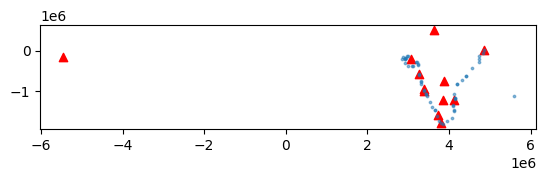

In [8]:
# Filtramos los aeropuertos que son de tipo 'large_airport'
# No usamos "airports.type" porque "type" es una palabra reservada en Python
largeAirports = airports[airports['kind'] == 'large_airport']

# Reiniciamos los índices después del filtrado para mantener un índice limpio y continuo
largeAirports.reset_index(drop=True, inplace=True)

# Graficamos los aeropuertos grandes y los puertos marítimos

# Graficamos los aeropuertos grandes como triángulos rojos en el mapa
base = largeAirports.plot(color='red', marker="^")

# Sobre la base anterior (aeropuertos), graficamos los puertos marítimos de India
# Ajustamos la transparencia (alpha) y el tamaño de los marcadores (markersize)
seaports_in_24378.plot(ax=base, alpha=0.5, markersize=3)

In [9]:
# No incluiremos el aeropuerto que está muy lejos, ya que parece ser un error

# Especificamos la lista de índices de los aeropuertos que queremos eliminar
# En este caso, eliminamos el aeropuerto con índice 9
notKeeping = [9]

# Eliminamos el aeropuerto del GeoDataFrame usando `drop()`
largeAirports.drop(index=notKeeping, inplace=True)

# Verificamos el resultado: mostramos el GeoDataFrame actualizado
largeAirports

<ipython-input-9-db21cb0ee8bc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  largeAirports.drop(index=notKeeping, inplace=True)


name           kind  \
0                 Indira Gandhi International Airport  large_airport   
1           Chhatrapati Shivaji International Airport  large_airport   
2                       Chennai International Airport  large_airport   
3                    Kempegowda International Airport  large_airport   
4   Netaji Subhash Chandra Bose International Airport  large_airport   
5                                     Dabolim Airport  large_airport   
6                  Rajiv Gandhi International Airport  large_airport   
7                        Cochin International Airport  large_airport   
8            Thiruvananthapuram International Airport  large_airport   
10                      Manohar International Airport  large_airport   
11                       Rajkot International Airport  large_airport   

    latitude_deg  longitude_deg  elevation_ft  \
0      28.555630      77.095190         777.0   
1      19.088699      72.867897          39.0   
2      12.990005      80.169296          52.0   
3      13.197900      77.706299        3000.0   
4      22.654699      88.446701          16.0   
5      15.380800      73.831398         150.0   
6      17.231318      78.429855        2024.0   
7      10.152000      76.401901          30.0   
8       8.482120      76.920097          15.0   
10     15.744257      73.860625         552.0   
11     22.378824      71.039391         647.0   

                           region_name        municipality  \
0   Delhi (National Capital Territory)           New Delhi   
1                          Maharashtra              Mumbai   
2                           Tamil Nadu             Chennai   
3                            Karnataka           Bangalore   
4                          West Bengal             Kolkata   
5                                  Goa       Vasco da Gama   
6                            Telangana           Hyderabad   
7                               Kerala               Kochi   
8                               Kerala  Thiruvananthapuram   
10                                 Goa                Mopa   
11                             Gujarat              Rajkot   

                            geometry  
0     POINT (3633095.495 515325.631)  
1    POINT (3268274.228 -570766.308)  
2   POINT (4133330.538 -1204758.786)  
3   POINT (3850646.637 -1209475.503)  
4      POINT (4859299.409 23033.632)  
5    POINT (3395287.625 -988979.096)  
6      POINT (3887479.897 -738327.8)  
7   POINT (3730354.442 -1579292.478)  
8    POINT (3807754.324 -1772954.52)  
10   POINT (3396252.235 -946987.828)  
11   POINT (3060527.463 -206910.991)

In [10]:
# Reiniciamos los índices del GeoDataFrame después de haber eliminado filas
# Esto es útil para asegurarnos de que los índices sean consecutivos y claros
# `drop=True` elimina los índices originales (no los convierte en una nueva columna)
# `inplace=True` aplica los cambios directamente en el GeoDataFrame sin crear una copia
largeAirports.reset_index(drop=True, inplace=True)

<Axes: >

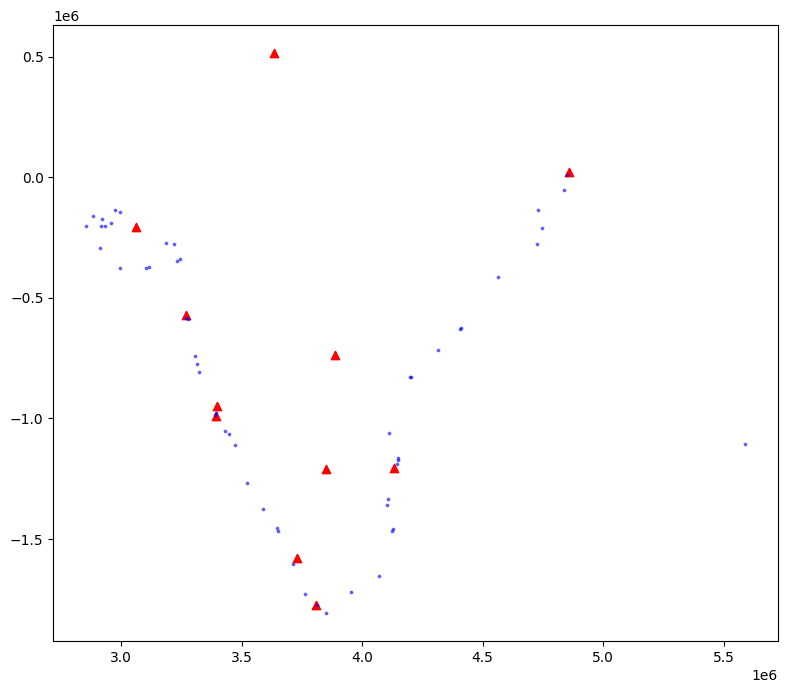

In [11]:
# Graficamos los aeropuertos grandes en el mapa
# Usamos color rojo ('red') para los puntos y los marcamos con un triángulo ("^")
base = largeAirports.plot(
    color='red',        # Color de los puntos
    marker="^",         # Forma de los puntos (triángulos)
    figsize=(10, 8)     # Tamaño del gráfico (opcional)
)

# Sobre la base anterior, graficamos los puertos marítimos reproyectados
seaports_in_24378.plot(
    ax=base,            # Agregamos los puntos al mismo gráfico base (aeropuertos)
    alpha=0.5,          # Transparencia de los puntos
    markersize=3,       # Tamaño de los puntos
    color='blue'        # (Opcional) Color azul para los puertos marítimos
)

**Ejercicio 1**

Utilice dos mapas de puntos de su país.

Calcule la matriz de distancias para ambos mapas.

Seleccione una fila de la matriz de distancias y trace los dos puntos con la distancia mínima sobre el país que elija.

In [12]:
# Trabajamos con puertos marítimos y aeropuertos grandes
# La matriz de distancia que estamos creando estará en kilómetros
# y los nombres estarán ordenados alfabéticamente para facilitar el acceso

distanceMatrixKM_sea_air = seaports_in_24378.set_index('portName').geometry.apply(
    # Usamos lambda para calcular la distancia desde cada puerto marítimo a todos los aeropuertos grandes
    lambda g: largeAirports.set_index('name').geometry.distance(g) / 1000  # Convertimos las distancias a kilómetros
).sort_index(axis=0).sort_index(axis=1)  # Ordenamos por nombres de puerto (filas) y aeropuertos (columnas)

In [13]:
# Revisamos el contenido de la matriz de distancias calculada

# Los valores en las celdas son las distancias en kilómetros (calculadas previamente)
distanceMatrixKM_sea_air

name                                 Chennai International Airport  \
portName                                                             
Azhikal (Azhikkal)                                      572.311418   
Baleshwar                                              1224.463315   
Bedi                                                   1555.601039   
Belekeri                                                698.976710   
Beypore                                                 548.025813   
Bhavnagar                                              1328.562945   
Calcutta                                               1409.734998   
Calicut (Kozhikode)                                     547.646602   
Chennai (Madras)                                         19.709157   
Cuddalore                                               156.224295   
Dahej                                                  1301.693722   
Dhamra                                                 1168.481763   
Gangavaram                                              637.151426   
Gopalpur                                                900.089463   
Haldia Port                                            1347.676978   
Hazira                                                 1243.714613   
Honavar                                                 667.798759   
Jafarabad                                              1323.253107   
Jaigarh Bay                                             924.759771   
Jawaharlal Nehru Port (Nhava Shiva)                    1055.742582   
Kakinada Bay                                            522.350960   
Kamarajar Port                                           37.341569   
Kandla                                                 1577.702893   
Karaikal Port                                           255.730382   
Karwar                                                  718.812417   
Kattupalli Port                                          42.471691   
Kochi (Cochin)                                          579.398917   
Kolachel                                                665.750233   
Krishnapatnam                                           146.653927   
Machilipatnam                                           382.237857   
Machilipatnam                                           382.785719   
Magdalla                                               1240.667403   
Mandvi                                                 1629.268209   
Marmagao                                                774.191041   
Mumbai (Bombay)                                        1063.974143   
Mundra                                                 1593.548068   
Nagappattinam                                           263.805130   
Navlakhi                                               1554.493313   
New Mangalore                                           612.987113   
Okha                                                   1624.756428   
Pamban                                                  451.300432   
Panaji                                                  775.162837   
Paradip                                                1102.207602   
Pipavav Bandar                                         1316.270646   
Pondicherry                                             129.619976   
Porbandar                                              1523.933030   
Port Blair                                             1456.483549   
Port Dabhol                                             946.314329   
Quilon (Kollam)                                         641.850945   
Ratnagiri                                               900.382879   
Sikka                                                  1561.836233   
Trivandrum                                              652.720434   
Tuticorin                                               547.670815   
Vadinar Terminal                                       1577.468614   
Veraval                                                1409.429185   
Vishakhapa

In [14]:
# Seleccionamos uno de los puertos marítimos, en este caso, "Panaji"
# Queremos encontrar los aeropuertos más cercanos a este puerto

# Usamos `.loc['Panaji', :]` para extraer la fila correspondiente al puerto "Panaji"
# Esto nos da las distancias de "Panaji" a todos los aeropuertos grandes

# Usamos `.sort_values(ascending=True)` para ordenar las distancias de menor a mayor
# Esto nos permite identificar rápidamente los aeropuertos más cercanos
distanceMatrixKM_sea_air.loc['Panaji', :].sort_values(ascending=True)

name
Dabolim Airport                                        13.839855
Manohar International Airport                          28.558481
Chhatrapati Shivaji International Airport             423.339272
Kempegowda International Airport                      514.153969
Rajiv Gandhi International Airport                    548.447845
Cochin International Airport                          691.830399
Chennai International Airport                         775.162837
Rajkot International Airport                          837.234826
Thiruvananthapuram International Airport              899.047414
Indira Gandhi International Airport                  1509.902417
Netaji Subhash Chandra Bose International Airport    1774.010833
Name: Panaji, dtype: float64

In [15]:
# Seleccionamos los dos aeropuertos más cercanos
# Usamos sus índices en el DataFrame `airports`, en este caso (5, 172)
Closest_Air = airports.loc[(5, 172), :]

# Mostramos los datos de los dos aeropuertos seleccionados
Closest_Air

name           kind  latitude_deg  \
5                  Dabolim Airport  large_airport     15.380800   
172  Manohar International Airport  large_airport     15.744257   

     longitude_deg  elevation_ft region_name   municipality  \
5        73.831398         150.0         Goa  Vasco da Gama   
172      73.860625         552.0         Goa           Mopa   

                            geometry  
5    POINT (3395287.625 -988979.096)  
172  POINT (3396252.235 -946987.828)

In [16]:
# Instalamos la librería mapclassify
# Esta librería se utiliza para clasificar datos continuos en intervalos o categorías
# Es especialmente útil en la creación de mapas temáticos con GeoPandas
!pip install mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.3 MB/s eta 0:00:00


In [17]:
# Graficamos los dos aeropuertos más cercanos en el mapa
# Usamos la función explore() para crear un mapa interactivo
# Los puntos de los aeropuertos se muestran en color rojo con un radio de 10
base = Closest_Air.explore(
    color='red',                     # Color de los puntos de los aeropuertos
    marker_kwds=dict(radius=10)      # Configuración de los marcadores: radio de 10
)

# Sobre el mismo mapa (base), graficamos el puerto marítimo de Panaji
seaports_in_24378[
    seaports_in_24378.portName.str.contains('Panaji')  # Filtramos el puerto con nombre "Panaji"
].explore(
    m=base,                          # Agregamos el puerto marítimo al mapa existente
    marker_kwds=dict(radius=10)      # Configuración del marcador del puerto: radio de 10
)


**Ejercicio 2**

Utilice un mapa de puntos y un mapa de líneas de su país.

Calcule la matriz de distancias para ambos.

Seleccione una línea de la matriz de distancias y trace el punto más cercano y el más lejano a esa línea.

In [18]:
# Revisamos qué información tenemos sobre los ríos
# El DataFrame 'rivers' contiene datos geoespaciales sobre los ríos disponibles
# Esto incluye nombres, geometrías y posiblemente otros atributos de los ríos
rivers

NAME SYSTEM                                           geometry
0       Ganges   None  LINESTRING (3890449.339 797278.081, 3885180.07...
1  Brahmaputra   None  LINESTRING (5359670.918 873592.559, 5346146.45...
2        Indus   None  MULTILINESTRING ((2768998.497 -54259.315, 2767...

In [19]:
# Seleccionamos las filas del GeoDataFrame 'rivers' relacionadas con el río Ganges
# Usamos la columna 'NAME' para buscar ríos cuyo nombre contenga la palabra 'Ganges'
Ganges = rivers[rivers.NAME.str.contains('Ganges')]

# El resultado es un subconjunto del GeoDataFrame 'rivers' que incluye
# únicamente las geometrías y datos relacionados con el río Ganges

In [20]:
# Creamos una matriz de distancias entre los aeropuertos grandes y las secciones del río Ganges
# La matriz contendrá las distancias en kilómetros

distanceMatrixKM_Ganges_air = Ganges.set_index('NAME').geometry.apply(
    # Para cada geometría del río Ganges, calculamos la distancia a los aeropuertos
    lambda g: largeAirports.set_index('name').geometry.distance(g) / 1000  # Convertimos de metros a kilómetros
).sort_index(axis=0).sort_index(axis=1)  # Ordenamos los índices y columnas alfabéticamente

# Mostramos la matriz de distancias
distanceMatrixKM_Ganges_air

name    Chennai International Airport  \
NAME                                    
Ganges                    1415.001311   

name    Chhatrapati Shivaji International Airport  \
NAME                                                
Ganges                                1153.041373   

name    Cochin International Airport  Dabolim Airport  \
NAME                                                    
Ganges                   1848.548739      1431.653342   

name    Indira Gandhi International Airport  Kempegowda International Airport  \
NAME                                                                            
Ganges                           126.566956                        1460.48128   

name    Manohar International Airport  \
NAME                                    
Ganges                    1393.720243   

name    Netaji Subhash Chandra Bose International Airport  \
NAME                                                        
Ganges                                         256.402906   

name    Rajiv Gandhi International Airport  Rajkot International Airport  \
NAME                                                                       
Ganges                          997.147547                   1008.302465   

name    Thiruvananthapuram International Airport  
NAME                                              
Ganges                               2020.025785

In [21]:
# Verificamos el orden de las distancias desde el primer segmento del río Ganges hacia los aeropuertos
# Seleccionamos la primera fila de la matriz de distancias (correspondiente al primer segmento del río Ganges)
# y ordenamos las distancias en orden ascendente para identificar los aeropuertos más cercanos

distanceMatrixKM_Ganges_air.iloc[0, :].sort_values(axis=0, ascending=True)

name
Indira Gandhi International Airport                   126.566956
Netaji Subhash Chandra Bose International Airport     256.402906
Rajiv Gandhi International Airport                    997.147547
Rajkot International Airport                         1008.302465
Chhatrapati Shivaji International Airport            1153.041373
Manohar International Airport                        1393.720243
Chennai International Airport                        1415.001311
Dabolim Airport                                      1431.653342
Kempegowda International Airport                     1460.481280
Cochin International Airport                         1848.548739
Thiruvananthapuram International Airport             2020.025785
Name: Ganges, dtype: float64

In [22]:
# Identificamos el aeropuerto más cercano para cada segmento del río Ganges
# Utilizamos idxmin(axis=1) para encontrar el índice (nombre del aeropuerto) con la menor distancia
# axis=1 indica que estamos operando fila por fila, es decir, para cada segmento del río
distanceMatrixKM_Ganges_air.idxmin(axis=1)

NAME
Ganges    Indira Gandhi International Airport
dtype: object

In [23]:
# Identificamos el aeropuerto más lejano para cada segmento del río Ganges
# Utilizamos idxmax(axis=1) para encontrar el índice (nombre del aeropuerto) con la mayor distancia
# axis=1 indica que estamos operando fila por fila, es decir, para cada segmento del río
distanceMatrixKM_Ganges_air.idxmax(axis=1)

NAME
Ganges    Thiruvananthapuram International Airport
dtype: object

In [24]:
# Filtramos los aeropuertos cuyo nombre contiene la palabra "Thiru"
# Usamos la columna 'name' del GeoDataFrame 'airports' y aplicamos el método str.contains()
# Esto selecciona solo las filas donde el nombre del aeropuerto incluye "Thiru"
airports[airports.name.str.contains('Thiru')]

name           kind  latitude_deg  \
9  Thiruvananthapuram International Airport  large_airport       8.48212   

   longitude_deg  elevation_ft region_name        municipality  \
9      76.920097          15.0      Kerala  Thiruvananthapuram   

                          geometry  
9  POINT (3807754.324 -1772954.52)

In [25]:
# Seleccionamos dos aeropuertos específicos usando sus índices en el GeoDataFrame 'airports'
# En este caso, seleccionamos los aeropuertos con índices 0 y 9
# Usamos .loc para acceder a las filas por índice y seleccionamos todas las columnas (indicado por ':')
Clos_Far_Air = airports.loc[(0, 9), :]

# Ahora, los aeropuertos seleccionados se almacenan en el GeoDataFrame 'Clos_Far_Air'
# Este subconjunto puede usarse para graficar o realizar análisis adicionales

In [26]:
Clos_Far_Air

name           kind  latitude_deg  \
0       Indira Gandhi International Airport  large_airport      28.55563   
9  Thiruvananthapuram International Airport  large_airport       8.48212   

   longitude_deg  elevation_ft                         region_name  \
0      77.095190         777.0  Delhi (National Capital Territory)   
9      76.920097          15.0                              Kerala   

         municipality                         geometry  
0           New Delhi   POINT (3633095.495 515325.631)  
9  Thiruvananthapuram  POINT (3807754.324 -1772954.52)

In [27]:
# Primero, graficamos los aeropuertos seleccionados (primer y último en la lista)
# Usamos la función explore() para generar un mapa interactivo
# Los aeropuertos se muestran en color rojo y los marcadores tienen un radio de 10
base = Clos_Far_Air.explore(
    color='red',                    # Color de los marcadores para los aeropuertos
    marker_kwds=dict(radius=10)     # Configuración del tamaño del marcador
)

# Luego, agregamos al mismo mapa (base) el río Ganges
# Filtramos las filas de 'rivers' cuyo nombre contiene 'Ganges'
# Usamos explore() nuevamente para agregar esta capa al mapa interactivo existente
rivers[rivers.NAME.str.contains('Ganges')].explore(
    m=base                          # Agregamos la capa al mapa interactivo ya creado
)

**Ejercicio 3**

Crear un CASCO para un conjunto de mapas de líneas.

Calcular la matriz de distancia entre los CASCO y un mapa de puntos.

Dibuje los CASCO y los puntos. Muestre los puntos más cercanos y más lejanos al CASCO.

In [28]:
# Filtramos los ríos que tienen datos disponibles en la columna "SYSTEM"
# Usamos .isna() para identificar valores nulos (NaN) en la columna "SYSTEM"
# El operador ~ invierte la condición, seleccionando solo las filas donde "SYSTEM" no es nulo
rivers[~rivers.SYSTEM.isna()]

Empty GeoDataFrame
Columns: [NAME, SYSTEM, geometry]
Index: []

In [30]:
# Probamos con este conjunto de datos de ríos para India
# Usamos geopandas para leer el archivo shapefile (.shp) directamente desde la URL proporcionada
# El archivo contiene información geoespacial sobre los ríos de la India
indiaRivers = gpd.read_file("https://github.com/in-Sinergy/IndiaData/raw/main/Rivers/Rivers.shp")

# Visualizamos las primeras filas del GeoDataFrame para entender su estructura y contenido
indiaRivers.head()

objectid         rivname rilcode  \
0       155            Ajay       1   
1       223       Alaknanda       1   
2       351            Amba       1   
3       575       Andi Odai       1   
4       578  Andrangi Drain       1   

                                              origin major_trib bacode  \
0  Near Deoghar In The Santhal Parganas District ...       None     2A   
1                                  Garhwal Himalayas       None     2A   
2                                               None       None     14   
3                                               None       None     05   
4                                               None       None     03   

                                  ba_name  \
0                                   Ganga   
1                                   Ganga   
2  West flowing rivers from Tapi to Tadri   
3                                 Cauvery   
4                                Godavari   

                             sub_basin     shape_Leng  \
0  Bhagirathi and others (Ganga Lower)  308394.210815   
1            Above Ramganga Confluence  206397.550749   
2                   Bhatsol and others  103041.275292   
3                        Cauvery Lower   16491.503072   
4                       Godavari Lower   13356.828787   

                                            geometry  
0  LINESTRING (4625672.355 4066335.487, 4625679.0...  
1  LINESTRING (3927501.39 4742662.37, 3927535.171...  
2  LINESTRING (3311469.037 3447641.467, 3311387.3...  
3  LINESTRING (3889172.463 2576115.624, 3889182.8...  
4  LINESTRING (4217069.63 3215665.789, 4217109.91...

In [31]:
# Seleccionamos únicamente las columnas que queremos conservar en el GeoDataFrame indiaRivers

keep = ['rivname', 'ba_name', 'sub_basin', 'geometry']

# Creamos un conjunto con las columnas que no queremos mantener
# Esto se hace restando las columnas a conservar del conjunto total de columnas
dontKeep = set(indiaRivers.columns.to_list()) - set(keep)

# Eliminamos las columnas no deseadas del GeoDataFrame
# Usamos drop() con el argumento columns=dontKeep para eliminar las columnas innecesarias
indiaRivers = indiaRivers.drop(columns=dontKeep)

# Mostramos el GeoDataFrame actualizado para verificar que solo contiene las columnas seleccionadas
indiaRivers

rivname                                            ba_name  \
0              Ajay                                              Ganga   
1         Alaknanda                                              Ganga   
2              Amba             West flowing rivers from Tapi to Tadri   
3         Andi Odai                                            Cauvery   
4    Andrangi Drain                                           Godavari   
..              ...                                                ...   
105        Ghaghara                                              Ganga   
106      Karnaphuli  Minor rivers draining into Myanmar and Bangladesh   
107          Satluj                               Indus (Up to border)   
108         Krishna                                            Krishna   
109            Musi                                            Krishna   

                               sub_basin  \
0    Bhagirathi and others (Ganga Lower)   
1              Above Ramganga Confluence   
2                     Bhatsol and others   
3                          Cauvery Lower   
4                         Godavari Lower   
..                                   ...   
105                                 None   
106            Khawthlangtuipui & Others   
107                                 None   
108                                 None   
109                        Krishna Lower   

                                              geometry  
0    LINESTRING (4625672.355 4066335.487, 4625679.0...  
1    LINESTRING (3927501.39 4742662.37, 3927535.171...  
2    LINESTRING (3311469.037 3447641.467, 3311387.3...  
3    LINESTRING (3889172.463 2576115.624, 3889182.8...  
4    LINESTRING (4217069.63 3215665.789, 4217109.91...  
..                                                 ...  
105  MULTILINESTRING ((4460395.803 4198399.029, 446...  
106  LINESTRING (5258047.759 3940507.574, 5258006.9...  
107  MULTILINESTRING ((3852813.193 4832742.626, 385...  
108  MULTILINESTRING ((4088071.262 3097425.887, 408...  
109  LINESTRING (3783499.387 3266641.072, 3783537.5...  

[110 rows x 4 columns]

In [32]:
# Reproyectamos el GeoDataFrame indiaRivers al sistema de referencia EPSG:24378
# EPSG:24378 es un sistema proyectado específico para la región de la India (metros como unidades)
indiaRivers_24378 = indiaRivers.to_crs(24378)

# Guardamos el GeoDataFrame reproyectado en una nueva variable 'indiaRivers_24378'
# Esto asegura que los datos estén listos para análisis espaciales precisos, como mediciones de distancia o área

In [33]:
# Creamos sistemas agrupando los ríos según la columna 'ba_name' (nombre de la cuenca)
# El método dissolve combina todas las geometrías que comparten el mismo valor en la columna 'ba_name'
# Además, agrega (suma) cualquier dato numérico en las otras columnas si existe
systems = indiaRivers.dissolve(by='ba_name')

# Mostramos el GeoDataFrame resultante para verificar los sistemas creados
systems

geometry  \
ba_name                                                                                                 
Barak and Others                                    MULTILINESTRING ((5288748.709 3932527.946, 528...   
Brahamaputra                                        MULTILINESTRING ((4978147.503 4244352.538, 497...   
Brahmani and Baitarni                               MULTILINESTRING ((4563923.291 3736285.855, 456...   
Cauvery                                             MULTILINESTRING ((3889172.463 2576115.624, 388...   
East flowing rivers between Mahanadi and Pennar     MULTILINESTRING ((4334629.197 3536488.174, 433...   
East flowing rivers between Pennar and Kanyakumari  MULTILINESTRING ((3739066.946 2438280.8, 37390...   
Ganga                                               MULTILINESTRING ((4625672.355 4066335.487, 462...   
Godavari                                            MULTILINESTRING ((4217069.63 3215665.789, 4217...   
Indus (Up to border)                                MULTILINESTRING ((3524182.205 4787176.053, 352...   
Krishna                                             MULTILINESTRING ((3995456.205 3356736.843, 399...   
Mahanadi                                            MULTILINESTRING ((4204505.083 3591194.783, 420...   
Mahi                                                LINESTRING (3274454.926 3827805.414, 3275173.3...   
Minor rivers draining into Myanmar and Bangladesh   MULTILINESTRING ((5437586.451 4197613.497, 543...   
Narmada                                             MULTILINESTRING ((3247998.347 3762883.916, 324...   
Pennar                                              LINESTRING (3748833.819 2845567.638, 3748826.3...   
Sabarmati                                           MULTILINESTRING ((3237854.247 3863836.724, 323...   
Subernarekha                                        LINESTRING (4522769.98 3937471.383, 4522770.43...   
Tapi                                                LINESTRING (3823678.458 3760252.65, 3823659.34...   
West flowing rivers from Tadri to Kanyakumari       MULTILINESTRING ((3621158.858 2559113.37, 3621...   
West flowing rivers from Tapi to Tadri              MULTILINESTRING ((3311469.037 3447641.467, 331...   
West flowing rivers of Kutch and Saurashtra inc...  MULTILINESTRING ((3373999.487 4241508.668, 337...   

                                                                  rivname  \
ba_name                                                                     
Barak and Others                                               Dhaleswari   
Brahamaputra                                                  Brahmaputra   
Brahmani and Baitarni                                           Baitarani   
Cauvery                                                         Andi Odai   
East flowing rivers between Mahanadi and Pennar                  Nagavali   
East flowing rivers between Pennar and Kanyakumari                 Arjuna   
Ganga                                                                Ajay   
Godavari                                                   Andrangi Drain   
Indus (Up to border)                                                 Beas   
Krishna                                                            Muneru   
Mahanadi                                                         Mahanadi   
Mahi                                                                 Mahi   
Minor rivers draining into Myanmar and Bangladesh             Chammu Ture   
Narmada                                                           Narmada   
Pennar                                                             Pennar   
Sabarmati                                                       Sabarmati   
Subernarekha                                                 Subarnarekha   
Tapi                                                                 Tapi   
West flowing rivers from Tadri to Kanyakumari       Bharathapuzha/Ponnani   
West flowing rivers from Tapi to Tadri                      

In [34]:
# Formateamos el GeoDataFrame 'systems' para simplificar su estructura

# Reiniciamos el índice del GeoDataFrame 'systems'
# drop=False mantiene la columna anterior del índice como parte del DataFrame
# inplace=True realiza el cambio directamente en el objeto sin crear una copia
systems.reset_index(drop=False, inplace=True)

# Eliminamos la columna 'sub_basin' ya que no es necesaria para el análisis
# inplace=True asegura que la modificación sea aplicada directamente al GeoDataFrame
systems.drop(columns='sub_basin', inplace=True)

# Mostramos el GeoDataFrame 'systems' actualizado para verificar los cambios realizados
systems

ba_name  \
0                                    Barak and Others   
1                                        Brahamaputra   
2                               Brahmani and Baitarni   
3                                             Cauvery   
4     East flowing rivers between Mahanadi and Pennar   
5   East flowing rivers between Pennar and Kanyaku...   
6                                               Ganga   
7                                            Godavari   
8                                Indus (Up to border)   
9                                             Krishna   
10                                           Mahanadi   
11                                               Mahi   
12  Minor rivers draining into Myanmar and Bangladesh   
13                                            Narmada   
14                                             Pennar   
15                                          Sabarmati   
16                                       Subernarekha   
17                                               Tapi   
18      West flowing rivers from Tadri to Kanyakumari   
19             West flowing rivers from Tapi to Tadri   
20  West flowing rivers of Kutch and Saurashtra in...   

                                             geometry                rivname  
0   MULTILINESTRING ((5288748.709 3932527.946, 528...             Dhaleswari  
1   MULTILINESTRING ((4978147.503 4244352.538, 497...            Brahmaputra  
2   MULTILINESTRING ((4563923.291 3736285.855, 456...              Baitarani  
3   MULTILINESTRING ((3889172.463 2576115.624, 388...              Andi Odai  
4   MULTILINESTRING ((4334629.197 3536488.174, 433...               Nagavali  
5   MULTILINESTRING ((3739066.946 2438280.8, 37390...                 Arjuna  
6   MULTILINESTRING ((4625672.355 4066335.487, 462...                   Ajay  
7   MULTILINESTRING ((4217069.63 3215665.789, 4217...         Andrangi Drain  
8   MULTILINESTRING ((3524182.205 4787176.053, 352...                   Beas  
9   MULTILINESTRING ((3995456.205 3356736.843, 399...                 Muneru  
10  MULTILINESTRING ((4204505.083 3591194.783, 420...               Mahanadi  
11  LINESTRING (3274454.926 3827805.414, 3275173.3...                   Mahi  
12  MULTILINESTRING ((5437586.451 4197613.497, 543...            Chammu Ture  
13  MULTILINESTRING ((3247998.347 3762883.916, 324...                Narmada  
14  LINESTRING (3748833.819 2845567.638, 3748826.3...                 Pennar  
15  MULTILINESTRING ((3237854.247 3863836.724, 323...              Sabarmati  
16  LINESTRING (4522769.98 3937471.383, 4522770.43...           Subarnarekha  
17  LINESTRING (3823678.458 3760252.65, 3823659.34...                   Tapi  
18  MULTILINESTRING ((3621158.858 2559113.37, 3621...  Bharathapuzha/Ponnani  
19  MULTILINESTRING ((3311469.037 3447641.467, 331...                   Amba  
20  MULTILINESTRING ((3373999.487 4241508.668, 337...                 Guhiya

In [35]:
# Reproyectamos el GeoDataFrame 'systems' al sistema de referencia de coordenadas EPSG:24378
# EPSG:24378 es un sistema proyectado para India, adecuado para cálculos espaciales precisos (distancias y áreas)
systems_24378 = systems.to_crs(24378)

# Ahora, el GeoDataFrame 'systems_24378' tiene las geometrías transformadas al nuevo sistema de referencia
# Esto es necesario antes de trabajar con cálculos como los convex hulls, que requieren un CRS en metros

<Axes: >

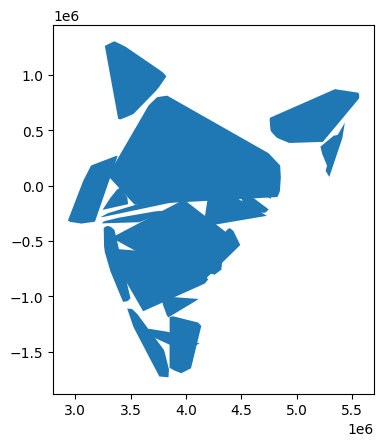

In [36]:
# Calculamos las envolventes convexas (convex hulls) de los sistemas en el GeoDataFrame 'systems_24378'
# La propiedad convex_hull genera el menor polígono convexo que encierra cada geometría
# Esto es útil para resumir la extensión espacial de un sistema de ríos
systems_24378.convex_hull.plot()

# Graficamos las envolventes convexas
# El método plot() visualiza las geometrías de los convex hulls en un gráfico simple

In [37]:
# Tenemos demasiados hulls (envolventes convexas), por lo que trabajaremos solo con dos de ellos
# Seleccionamos dos sistemas específicos usando sus índices 3 y 8 del GeoDataFrame 'systems_24378'
# Usamos .loc para acceder a las filas por índice y seleccionamos todas las columnas (indicado por ':')
systemsKeep = systems_24378.loc[(3, 8), :]

# El nuevo GeoDataFrame 'systemsKeep' contiene únicamente los dos sistemas seleccionados
# Esto permite centrarnos en un subconjunto más pequeño para análisis o visualización

<Axes: >

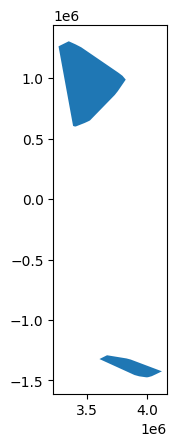

In [38]:
# Graficamos las envolventes convexas (convex hulls) de los sistemas seleccionados en 'systemsKeep'
# La propiedad convex_hull genera el menor polígono convexo que encierra cada geometría
# El método plot() muestra estos convex hulls en un gráfico estático
systemsKeep.convex_hull.plot()

In [39]:
# Creamos un GeoDataFrame para las envolventes convexas (hulls)
# Esto permitirá realizar cálculos, como una matriz de distancias, más adelante

# Convertimos las geometrías de convex hulls a un DataFrame
# 'to_frame()' crea un DataFrame con las geometrías
systems_hulls = systemsKeep.convex_hull.to_frame()

# Agregamos una columna con nombres descriptivos para los sistemas
# Esto asigna manualmente los nombres 'Cauvery' e 'Indus' a los sistemas seleccionados
systems_hulls['system'] = ['Cauvery', 'Indus']

# Renombramos la columna generada por 'to_frame' a 'geometry' para cumplir con el formato de un GeoDataFrame
systems_hulls.rename(columns={0: 'geometry'}, inplace=True)

# Convertimos el DataFrame en un GeoDataFrame configurando la geometría
# 'set_geometry' asegura que la columna 'geometry' sea reconocida como geometría espacial
systems_hulls = systems_hulls.set_geometry('geometry')

# Configuramos el sistema de referencia de coordenadas (CRS) para el GeoDataFrame
# EPSG:24378 es un sistema proyectado que utiliza metros, ideal para cálculos espaciales
systems_hulls.crs = "EPSG:24378"

# Mostramos el GeoDataFrame 'systems_hulls' actualizado
systems_hulls

geometry   system
3  POLYGON ((3991942.993 -1474484.465, 3991787.93...  Cauvery
8  POLYGON ((3405425.166 600245.226, 3395949.14 6...    Indus

In [40]:
# Creamos una matriz de distancias entre los sistemas (convex hulls) y los aeropuertos grandes
# El resultado será una matriz en kilómetros que muestra la distancia entre cada sistema y cada aeropuerto

distanceMatrixKM_sysHull_air = systems_hulls.set_index('system').geometry.apply(
    # Para cada geometría del sistema (convex hull), calculamos la distancia a todos los aeropuertos grandes
    lambda g: largeAirports.set_index('name').geometry.distance(g) / 1000  # Convertimos de metros a kilómetros
).sort_index(axis=0).sort_index(axis=1)  # Ordenamos los índices (sistemas y aeropuertos) alfabéticamente

# Mostramos la matriz de distancias para inspeccionar los resultados
distanceMatrixKM_sysHull_air

name     Chennai International Airport  \
system                                   
Cauvery                     210.032142   
Indus                      1945.058202   

name     Chhatrapati Shivaji International Airport  \
system                                               
Cauvery                                 823.765011   
Indus                                  1179.015857   

name     Cochin International Airport  Dabolim Airport  \
system                                                   
Cauvery                    180.916984       394.778009   
Indus                     2203.453193      1589.256655   

name     Indira Gandhi International Airport  \
system                                         
Cauvery                          1807.705511   
Indus                             171.982675   

name     Kempegowda International Airport  Manohar International Airport  \
system                                                                     
Cauvery                        111.030554                     430.457206   
Indus                         1863.236094                    1547.260245   

name     Netaji Subhash Chandra Bose International Airport  \
system                                                       
Cauvery                                        1624.903362   
Indus                                          1404.085693   

name     Rajiv Gandhi International Airport  Rajkot International Airport  \
system                                                                      
Cauvery                          581.889584                   1242.134821   
Indus                           1421.753326                    875.402674   

name     Thiruvananthapuram International Airport  
system                                             
Cauvery                                329.216898  
Indus                                 2406.862991

In [41]:
# Identificamos las columnas (aeropuertos) con la distancia mínima desde cada sistema
# Utilizamos idxmin(axis="columns") para obtener el índice (nombre del aeropuerto)
# correspondiente a la distancia más corta en cada fila (sistema)
mins = distanceMatrixKM_sysHull_air.idxmin(axis="columns")

# Mostramos los resultados: cada sistema y el aeropuerto más cercano
mins

system
Cauvery       Kempegowda International Airport
Indus      Indira Gandhi International Airport
dtype: object

In [42]:
# Identificamos las columnas (aeropuertos) con la distancia máxima desde cada sistema
# Utilizamos idxmax(axis="columns") para obtener el índice (nombre del aeropuerto)
# correspondiente a la distancia más grande en cada fila (sistema)
maxs = distanceMatrixKM_sysHull_air.idxmax(axis="columns")

# Mostramos los resultados: cada sistema y el aeropuerto más lejano
maxs

system
Cauvery         Indira Gandhi International Airport
Indus      Thiruvananthapuram International Airport
dtype: object

In [43]:
# Ahora graficamos todo en un mapa interactivo
# Iniciamos el mapa con las geometrías de los sistemas (convex hulls)
base = systems_hulls.explore()

# Agregamos los aeropuertos más cercanos al mapa
# Filtramos los aeropuertos que están en la lista 'mins' (los más cercanos) y los graficamos en color verde
largeAirports[largeAirports.name.isin(mins)].explore(
    m=base,                         # Agregamos esta capa al mapa base
    color='green',                  # Los puntos se mostrarán en color verde
    marker_kwds=dict(radius=10)     # Configuramos el tamaño del marcador
)

# Agregamos los aeropuertos más lejanos al mapa
# Filtramos los aeropuertos que están en la lista 'maxs' (los más lejanos) y los graficamos en color rojo
largeAirports[largeAirports.name.isin(maxs)].explore(
    m=base,                         # Agregamos esta capa al mapa base
    color='red',                    # Los puntos se mostrarán en color rojo
    marker_kwds=dict(radius=10)     # Configuramos el tamaño del marcador
)

# Agregamos los aeropuertos restantes al mapa
# Seleccionamos los aeropuertos que no están en las listas 'mins' ni 'maxs' y los graficamos en color azul
largeAirports[~largeAirports.name.isin(mins) & ~largeAirports.name.isin(maxs)].explore(
    m=base,                         # Agregamos esta capa al mapa base
    color='blue',                   # Los puntos se mostrarán en color azul
    marker_kwds=dict(radius=5)      # Configuramos un tamaño de marcador más pequeño
)

# Nota: Indira Gandhi Airport aparece en verde y rojo porque es el más cercano a un sistema y el más lejano a otro


**Ejercicio 4**

Selecciona un mapa de líneas y uno de puntos.

Obtén el área de influencia de las líneas y selecciona una distancia.

Conserva los puntos que están dentro del área de influencia (es posible que tengas que jugar con diferentes distancias hasta que encuentres algo interesante).

In [44]:
# Trabajamos con todos los ríos y aeropuertos grandes para calcular la matriz de distancias
# Creamos una matriz que muestra las distancias (en kilómetros) entre cada río y cada aeropuerto

distanceMatrixKM_riv_air = indiaRivers_24378.set_index('rivname').geometry.apply(
    # Para cada geometría de río (g), calculamos la distancia a todos los aeropuertos grandes
    lambda g: largeAirports.set_index('name').geometry.distance(g) / 1000  # Convertimos las distancias de metros a kilómetros
).sort_index(axis=0).sort_index(axis=1)  # Ordenamos los índices (nombres de ríos y nombres de aeropuertos) alfabéticamente

# Mostramos la matriz de distancias para inspeccionar los resultados
distanceMatrixKM_riv_air

name       Chennai International Airport  \
rivname                                    
Ajay                         1439.149917   
Alaknanda                    1944.495158   
Amba                         1004.096451   
Ambika                       1120.261576   
Andi Odai                     271.704089   
...                                  ...   
Wainganga                     757.458598   
Wainganga                     761.797515   
Wardha                        751.561057   
Yamuna                       1401.522466   
Zungki                       2136.508297   

name       Chhatrapati Shivaji International Airport  \
rivname                                                
Ajay                                     1534.431208   
Alaknanda                                1367.366564   
Amba                                       26.701158   
Ambika                                    186.514290   
Andi Odai                                1161.671576   
...                                              ...   
Wainganga                                 747.119562   
Wainganga                                 743.345894   
Wardha                                    601.745193   
Yamuna                                   1051.126909   
Zungki                                   2400.052640   

name       Cochin International Airport  Dabolim Airport  \
rivname                                                    
Ajay                        1952.467038      1684.506185   
Alaknanda                   2283.654116      1732.543431   
Amba                        1036.418043       366.105515   
Ambika                      1237.830724       589.997517   
Andi Odai                    319.001303       781.262342   
...                                 ...              ...   
Wainganga                   1156.043969       811.373560   
Wainganga                   1159.150887       812.701210   
Wardha                      1140.652956       764.341153   
Yamuna                      1814.154573      1366.814411   
Zungki                      2679.614408      2511.379402   

name       Indira Gandhi International Airport  \
rivname                                          
Ajay                               1026.010208   
Alaknanda                           228.829377   
Amba                               1161.637510   
Ambika                              939.850177   
Andi Odai                          2007.108878   
...                                        ...   
Wainganga                          1038.419110   
Wainganga                           728.180155   
Wardha                              763.561486   
Yamuna                               16.853645   
Zungki                             1780.150206   

name       Kempegowda International Airport  Manohar International Airport  \
rivname                                                                      
Ajay                            1572.666252                    1654.833412   
Alaknanda                       1915.615685                    1691.321798   
Amba                             792.115318                     325.849945   
Ambika                           949.657654                     548.209372   
Andi Odai                        298.995472                     806.182719   
...                                     ...                            ...   
Wainganga                        768.610414                     783.638473   
Wainganga                        771.851702                     784.921781   
Wardha                           754.062913                     729.792259   
Yamuna                          1428.310558                    1327.822098   
Zungki                          2320.433578                    2485.829396   

name       Netaji Subhash Chandra Bose International Airport  \
rivname                                                        
Ajay                                              114.312328   
Alaknanda                                        1249.08922

In [45]:
# Seleccionamos un valor específico de la matriz de distancias:
# la distancia máxima entre el río "Ganga" y todos los aeropuertos
distanceMatrixKM_riv_air.loc['Ganga'].max()

2005.997348176404

In [46]:
# Calculamos un buffer (zona de influencia) alrededor del río "Ganga"
# Usamos la distancia máxima entre el río "Ganga" y los aeropuertos, multiplicada por 10 como radio del buffer

# Obtenemos la distancia máxima entre el río "Ganga" y los aeropuertos, y la multiplicamos por 10
# Esto genera el radio del buffer en las unidades del CRS (en este caso, metros)
maxMts = distanceMatrixKM_riv_air.loc['Ganga'].max() * 10

# Creamos el buffer (un polígono) alrededor de la geometría del río "Ganga"
# Filtramos el GeoDataFrame indiaRivers_24378 para seleccionar solo el río "Ganga"
# Aplicamos el método .buffer() con el radio calculado para generar la zona de influencia
indiaRivers_24378[indiaRivers_24378.rivname == 'Ganga'].buffer(distance=maxMts)

20    POLYGON ((3696077.44 617940.225, 3696072.804 6...
dtype: geometry

In [47]:
# Visualizamos lo que hemos creado hasta ahora: el buffer y el río "Ganga"

# Creamos el buffer alrededor del río "Ganga"
# Usamos la distancia máxima calculada previamente como radio del buffer
bufferAroundGanga = indiaRivers_24378[indiaRivers_24378.rivname == 'Ganga'].buffer(distance=maxMts)

# Exploramos el buffer visualmente en un mapa interactivo
# Asignamos el color rojo para representar el área del buffer
bufferAsBase = bufferAroundGanga.explore(color='red')

# Agregamos la geometría original del río "Ganga" al mapa interactivo
# Usamos color azul para distinguir la línea del río dentro del buffer
# Modificamos el grosor de la línea con el argumento style_kwds
indiaRivers_24378[indiaRivers_24378.rivname == 'Ganga'].explore(
    m=bufferAsBase,                  # Añadimos esta capa al mapa base que ya tiene el buffer
    color='blue',                    # Usamos color azul para el río
    style_kwds={'weight': 0.5}       # Ajustamos el grosor de la línea
)

In [48]:
# Filtramos todos los aeropuertos pequeños dentro del buffer del río "Ganga"
# Esto es útil porque los aeropuertos pequeños son más numerosos que los de otros tamaños

# Filtramos los aeropuertos que son de tipo "small_airport" del GeoDataFrame de aeropuertos
small_airports = airports[airports['kind'] == 'small_airport']

# Usamos el método clip() para seleccionar únicamente los aeropuertos pequeños
# cuyas geometrías estén dentro del buffer alrededor del río "Ganga"
airportsWithinBuffer = small_airports.clip(mask=bufferAroundGanga)

# Mostramos los aeropuertos pequeños que se encuentran dentro del buffer
airportsWithinBuffer

name           kind  latitude_deg  longitude_deg  \
207  Kanpur Civil Airport (Old)  small_airport     26.440857      80.365029   
144          IIT Kanpur Airport  small_airport     26.520399      80.232904   
264              Benti Airstrip  small_airport     25.672920      81.495920   
267             Andhau Airfield  small_airport     25.615500      83.560640   
310     Bihta Air Force Station  small_airport     25.591240      84.883120   
263              Ulao Aerodrome  small_airport     25.427880      86.088190   
146               Malda Airport  small_airport     25.010180      88.126917   
135           Bhagalpur Airport  small_airport     25.249535      87.011976   
301        Mohammadabad Airport  small_airport     27.316258      79.451555   

     elevation_ft    region_name  municipality                        geometry  
207         411.0  Uttar Pradesh        Kanpur   POINT (3978964.328 314135.75)  
144         400.0  Uttar Pradesh        Kanpur   POINT (3964804.96 321404.263)  
264           NaN  Uttar Pradesh         Benti  POINT (4102200.113 243020.355)  
267           NaN  Uttar Pradesh       Biraich  POINT (4309663.292 265004.934)  
310           NaN          Bihar         Patna  POINT (4442151.332 282582.057)  
263           NaN          Bihar     Begusarai  POINT (4565365.332 284515.859)  
146          79.0    West Bengal         Malda   POINT (4777162.81 275544.132)  
135           NaN          Bihar     Bhagalpur  POINT (4660987.982 281132.681)  
301           NaN  Uttar Pradesh  Mohammadabad  POINT (3877603.554 400713.933)

In [49]:
# Ahora tenemos suficiente información para visualizar todo junto en un mapa interactivo

# Visualizamos el buffer alrededor del río "Ganga" como base del mapa
# El color rojo representa el área de influencia del río "Ganga"
bufferAsBase = bufferAroundGanga.explore(color='red')

# Añadimos la geometría del río "Ganga" al mapa
# Usamos color azul para destacar el río dentro del buffer
# Ajustamos el grosor de la línea con el argumento style_kwds
indiaRivers_24378[indiaRivers_24378.rivname == 'Ganga'].explore(
    m=bufferAsBase,                  # Añadimos esta capa al mapa base que ya tiene el buffer
    color='blue',                    # Usamos color azul para la línea del río
    style_kwds={'weight': 0.5}       # Ajustamos el grosor de la línea
)

# Añadimos los aeropuertos pequeños dentro del buffer al mapa
# Usamos color negro para representar estos aeropuertos
airportsWithinBuffer.explore(
    m=bufferAsBase,                  # Añadimos esta capa al mismo mapa base
    color='black'                    # Color negro para los aeropuertos pequeños
)